In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import json
import re
import json
import glob
import datetime
from collections import Counter

from datetime import datetime
import math
import scipy
import scipy.stats
import panel as pn
pn.extension()
from vega_datasets import data as vds

In [71]:
# Gerando os URL dos .csv
caminho = r'dados_aux/dados-sp-'
todos_dados_csv = glob.glob(caminho + "*.csv")

# Colunas que incluem datas
datas = ['dataNotificacao', 'dataInicioSintomas', 'dataTeste', 'dataEncerramento']

# Colunas a serem lidas
cols = ["dataNotificacao", "dataInicioSintomas", "sintomas", "profissionalSaude", "cbo","condicoes",
        "dataTeste", "tipoTeste", "resultadoTeste", "sexo", "municipio", "municipioIBGE", "estadoNotificacao",
        "estadoNotificacaoIBGE", "idade", "dataEncerramento", "evolucaoCaso", "classificacaoFinal"]

# Carregando os dados
dados = pd.concat((pd.read_csv(f, sep=';', encoding='latin1', parse_dates=datas, usecols=cols, infer_datetime_format = False) for f in todos_dados_csv), ignore_index = True)

In [72]:
# Exclui as linhas cujas colunas indicadas abaixo sao null
dados.dropna(subset = ["dataTeste","tipoTeste", "resultadoTeste", "classificacaoFinal"], inplace = True)

# Exclui os dados Cancelados
dados.drop(dados[dados['evolucaoCaso'] == 'Cancelado'].index, inplace = True)

# Exclui os dados que possuem datas fora do escopo esperado
data_limite_inferior = np.datetime64('2020-01-01', 'ns') # Comeco da pandemia
data_limite_superior = np.datetime64('2021-03-25', 'ns') # A publicacao dos dados mais recentes ocorreram nesse dia
for data in datas:
    dados[data] = pd.to_datetime(dados[data], utc=True).dt.tz_localize(None) # Retira o fuso horario
    dados.drop(dados[(dados[data] < data_limite_inferior) | (dados[data] > data_limite_superior)].index, inplace = True) # Exclui

dados[dados['idade'] > 116] = float("NaN") # Exclui idades invalidas
dados.reset_index(drop=True, inplace = True) # Realoca os indices depois das exclusoes

In [73]:
cidades = {}
for i in range(len(dados)):
    cidadeIBGE = dados['municipioIBGE'][i]
    if cidadeIBGE != cidadeIBGE: # Precisa disso pra pular os dados cujo campo municipioIBGE é NULL (float vira NaN)
        continue
    cidadeIBGE = int(cidadeIBGE)
    resultadoTeste = dados['resultadoTeste'][i]
    if cidadeIBGE not in cidades:
        cidades[cidadeIBGE] = {}
        cidades[cidadeIBGE]['Nome'] = dados['municipio'][i]
        cidades[cidadeIBGE]['Positivo'] = 0
        cidades[cidadeIBGE]['Negativo'] = 0
        cidades[cidadeIBGE]['Inconclusivo ou Indeterminado'] = 0

    # Precisa disso por causa dos NaN
    if resultadoTeste not in cidades[cidadeIBGE]:
        cidades[cidadeIBGE][resultadoTeste] = 0
    cidades[cidadeIBGE][resultadoTeste] += 1

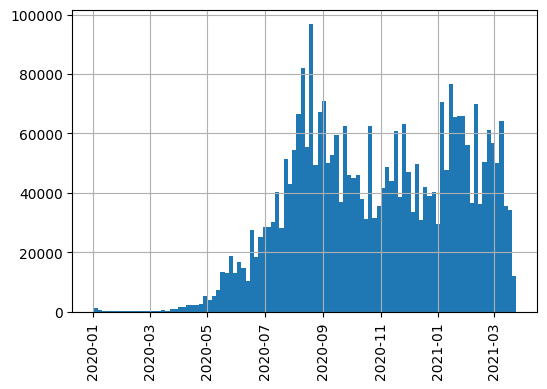

In [74]:
#Criando o histograma do número de testes com resultado e classificação final
dados['dataTeste'] = pd.to_datetime(dados['dataTeste'])
dados = dados.sort_values('dataTeste', ascending=True)
plt.figure(dpi=100)
dados['dataTeste'].hist(bins=100)
plt.xticks(rotation='vertical')
plt.show()

In [95]:
#Número total de testes realizados e que apresentam uma classificação final
total_testes = dados.shape[0]


#Número de falsos negativos dos testes
teste_RT_falsoneg = len(dados.query('tipoTeste == "RT-PCR" & resultadoTeste == "Negativo" & classificacaoFinal != "Descartado"'))
teste_anticorpo_falsoneg = len(dados.query('tipoTeste == "TESTE RÁPIDO - ANTICORPO" & resultadoTeste == "Negativo" & classificacaoFinal != "Descartado"'))
teste_antigeno_falsoneg = len(dados.query('tipoTeste == "TESTE RÁPIDO - ANTÍGENO" & resultadoTeste == "Negativo" & classificacaoFinal != "Descartado"'))
teste_ELISA_falsoneg = len(dados.query('(tipoTeste == "Enzimaimunoensaio - ELISA IgM" | tipoTeste == "Enzimaimunoensaio  ELISA") & resultadoTeste == "Negativo" & classificacaoFinal != "Descartado"'))
teste_CLIA_falsoneg = len(dados.query('(tipoTeste == "Quimioluminescência - CLIA" | tipoTeste == "Imunoensaio por Eletroquimioluminescência  ECLIA") & resultadoTeste == "Negativo" & classificacaoFinal != "Descartado"'))
teste_ECLIA_falsoneg = len(dados.query('tipoTeste == "Imunoensaio por Eletroquimioluminescência - ECLIA IgG" & resultadoTeste == "Negativo" & classificacaoFinal != "Descartado"'))


#Número de falsos positivos dos testes
teste_RT_falsoposi = len(dados.query('tipoTeste == "RT-PCR" & resultadoTeste == "Positivo" & (classificacaoFinal == "Descartado" | classificacaoFinal == "Síndrome Gripal não Especificada")'))
teste_anticorpo_falsoposi = len(dados.query('tipoTeste == "TESTE RÁPIDO - ANTICORPO" & (classificacaoFinal == "Descartado" | classificacaoFinal == "Síndrome Gripal não Especificada")'))
teste_antigeno_falsoposi = len(dados.query('tipoTeste == "TESTE RÁPIDO - ANTÍGENO" & resultadoTeste == "Positivo" & (classificacaoFinal == "Descartado" | classificacaoFinal == "Síndrome Gripal não Especificada")'))
teste_ELISA_falsoposi = len(dados.query('(tipoTeste == "Enzimaimunoensaio - ELISA IgM" | tipoTeste == "Enzimaimunoensaio  ELISA") & resultadoTeste == "Positivo" & (classificacaoFinal == "Descartado" | classificacaoFinal == "Síndrome Gripal não Especificada")'))
teste_CLIA_falsoposi = len(dados.query('(tipoTeste == "Quimioluminescência - CLIA" | tipoTeste == "Imunoensaio por Eletroquimioluminescência  ECLIA") & resultadoTeste == "Positivo" & (classificacaoFinal == "Descartado" | classificacaoFinal == "Síndrome Gripal não Especificada")'))
teste_ECLIA_falsoposi = len(dados.query('tipoTeste == "Imunoensaio por Eletroquimioluminescência - ECLIA IgG" & resultadoTeste == "Positivo" & (classificacaoFinal == "Descartado" | classificacaoFinal == "Síndrome Gripal não Especificada")'))


#Número total de testes realizados e que apresentam uma classificação final
total_RT = len(dados.query('tipoTeste == "RT-PCR"'))
total_anticorpo = len(dados.query('tipoTeste == "TESTE RÁPIDO - ANTICORPO" '))
total_antigeno = len(dados.query('tipoTeste == "TESTE RÁPIDO - ANTÍGENO" '))
total_ELISA = len(dados.query('(tipoTeste == "Enzimaimunoensaio - ELISA IgM" | tipoTeste == "Enzimaimunoensaio  ELISA")'))
total_CLIA = len(dados.query('(tipoTeste == "Quimioluminescência - CLIA" | tipoTeste == "Imunoensaio por Eletroquimioluminescência  ECLIA") '))
total_ECLIA = len(dados.query('tipoTeste == "Imunoensaio por Eletroquimioluminescência - ECLIA IgG"'))

probabilidade_falsoneg = [teste_RT_falsoneg/total_RT, teste_anticorpo_falsoneg/total_anticorpo, teste_antigeno_falsoneg/total_antigeno, teste_ELISA_falsoneg/total_ELISA, teste_CLIA_falsoneg/total_CLIA, teste_ECLIA_falsoneg/total_ECLIA]
probabilidade_falsoposi = [teste_RT_falsoposi/total_RT, teste_anticorpo_falsoposi/total_anticorpo, teste_antigeno_falsoposi/total_antigeno, teste_ELISA_falsoposi/total_ELISA, teste_CLIA_falsoposi/total_CLIA, teste_ECLIA_falsoposi/total_ECLIA]

print("Porcentagem de falsos negativos para cada teste:\n")
print('Teste RT-PCR : ',probabilidade_falsoneg[0] *100,'%')
print('Teste Rápido - Anticorpo : ',probabilidade_falsoneg[1]*100,'%')
print('Teste Rápido - Antígeno :',probabilidade_falsoneg[2]*100,'%')
print('Teste Enzimaimunoensaio - ELISA : ',probabilidade_falsoneg[3]*100,'%')
print('Teste Quimioluminescência - CLIA : ',probabilidade_falsoneg[4]*100,'%')
print('Teste Imunoensaio por Eletroquimioluminescência - ECLIA IgG : ',probabilidade_falsoneg[5]*100,'%')

print("\nPorcentagem de falsos positivos para cada teste:\n")

print('Teste RT-PCR : ',probabilidade_falsoposi[0] *100,'%')
print('Teste Rápido - Anticorpo : ',probabilidade_falsoposi[1]*100,'%')
print('Teste Rápido - Antígeno :',probabilidade_falsoposi[2]*100,'%')
print('Teste Enzimaimunoensaio - ELISA : ',probabilidade_falsoposi[3]*100,'%')
print('Teste Quimioluminescência - CLIA : ',probabilidade_falsoposi[4]*100,'%')
print('Teste Imunoensaio por Eletroquimioluminescência - ECLIA IgG : ',probabilidade_falsoposi[5]*100,'%')

Porcentagem de falsos negativos para cada teste:

Teste RT-PCR :  14.823144356005615 %
Teste Rápido - Anticorpo :  14.621331064437884 %
Teste Rápido - Antígeno : 12.526294748665034 %
Teste Enzimaimunoensaio - ELISA :  12.950115626032375 %
Teste Quimioluminescência - CLIA :  2.8238616307800917 %
Teste Imunoensaio por Eletroquimioluminescência - ECLIA IgG :  3.8476337052712584 %

Porcentagem de falsos positivos para cada teste:

Teste RT-PCR :  0.34023461723724907 %
Teste Rápido - Anticorpo :  58.73140853280183 %
Teste Rápido - Antígeno : 0.4625972072835264 %
Teste Enzimaimunoensaio - ELISA :  0.16518004625041297 %
Teste Quimioluminescência - CLIA :  0.4941757853865161 %
Teste Imunoensaio por Eletroquimioluminescência - ECLIA IgG :  0.11542901115813775 %


In [104]:
def erro_otimista(alpha, probabilidade, total_casos):
    return abs(scipy.stats.norm.ppf(alpha/2)) *  math.sqrt(probabilidade *(1 - probabilidade)/total_casos)

def erro_conservativo(alpha, total_casos):
    return abs(scipy.stats.norm.ppf(alpha/2)) *  1/math.sqrt(4 * total_casos)

# A partir da análise pontual podemos encontrar a estimativa intervalar para cada teste com alpha = 1% = 0.01
alpha = 0.01

#Fazendo a análise para os casos falsos negativos

#Para o caso da abordagem otimista
erros_otimistas_falsoneg = [erro_otimista(alpha, probabilidade_falsoneg[0], total_RT),erro_otimista(alpha, probabilidade_falsoneg[1], total_anticorpo),
                   erro_otimista(alpha, probabilidade_falsoneg[2], total_antigeno), erro_otimista(alpha, probabilidade_falsoneg[3], total_ELISA),
                   erro_otimista(alpha, probabilidade_falsoneg[4], total_CLIA), erro_otimista(alpha, probabilidade_falsoneg[5], total_ECLIA)]



#Estimativa intervalar para a abordagem otimista
print('Considerando a abordagem otimista\n')
print('Teste RT-PCR : [',(probabilidade_falsoneg[0] - erros_otimistas_falsoneg[0])*100,";",(probabilidade_falsoneg[0] + erros_otimistas_falsoneg[0])*100,']')
print('Teste Rápido - Anticorpo : [',(probabilidade_falsoneg[1] - erros_otimistas_falsoneg[1])*100,";",(probabilidade_falsoneg[1] + erros_otimistas_falsoneg[1])*100,']')
print('Teste Rápido - Antígeno : [',(probabilidade_falsoneg[2] - erros_otimistas_falsoneg[2])*100,";",(probabilidade_falsoneg[2] + erros_otimistas_falsoneg[2])*100,']')
print('Teste Enzimaimunoensaio - ELISA : [',(probabilidade_falsoneg[3] - erros_otimistas_falsoneg[3])*100,";",(probabilidade_falsoneg[3] + erros_otimistas_falsoneg[3])*100,']')
print('Teste Quimioluminescência - CLIA : [',(probabilidade_falsoneg[4] - erros_otimistas_falsoneg[4])*100,";",(probabilidade_falsoneg[4] + erros_otimistas_falsoneg[4])*100,']')
print('Teste Imunoensaio por Eletroquimioluminescência - ECLIA IgG : [',(probabilidade_falsoneg[5] - erros_otimistas_falsoneg[5])*100,";",(probabilidade_falsoneg[5] + erros_otimistas_falsoneg[5])*100,']')

#Para o caso da abordagem conservativa
erros_conservativos_falsoneg = [erro_conservativo(alpha, total_RT), erro_conservativo(alpha, total_anticorpo), 
                                erro_conservativo(alpha, total_antigeno), erro_conservativo(alpha, total_ELISA),
                                erro_conservativo(alpha, total_CLIA), erro_conservativo(alpha, total_ECLIA)]


#Estimativa intervalar para a abordagem conservativa
print('\nConsiderando a abordagem conservativa\n')
print('Teste RT-PCR : [',(probabilidade_falsoneg[0] - erros_conservativos_falsoneg[0])*100,";",(probabilidade_falsoneg[0] + erros_conservativos_falsoneg[0])*100,']')
print('Teste Rápido - Anticorpo : [',(probabilidade_falsoneg[1]  - erros_conservativos_falsoneg[1])*100,";",(probabilidade_falsoneg[1]  + erros_conservativos_falsoneg[1])*100,']')
print('Teste Rápido - Antígeno : [',(probabilidade_falsoneg[2]  - erros_conservativos_falsoneg[2])*100,";",(probabilidade_falsoneg[2] + erros_conservativos_falsoneg[2])*100,']')
print('Teste Enzimaimunoensaio - ELISA : [',(probabilidade_falsoneg[3]  - erros_conservativos_falsoneg[3])*100,";",(probabilidade_falsoneg[3]  + erros_conservativos_falsoneg[3])*100,']')
print('Teste Quimioluminescência - CLIA : [',(probabilidade_falsoneg[4]  - erros_conservativos_falsoneg[4])*100,";",(probabilidade_falsoneg[4]  + erros_conservativos_falsoneg[4])*100,']')
print('Teste Imunoensaio por Eletroquimioluminescência - ECLIA IgG : [',(probabilidade_falsoneg[5]  - erros_conservativos_falsoneg[5])*100,";",(probabilidade_falsoneg[5] + erros_conservativos_falsoneg[5])*100,']')

#Fazendo a análise para os casos falsos positivos

erros_otimistas_falsoposi = [erro_otimista(alpha, probabilidade_falsoposi[0], total_RT),erro_otimista(alpha, probabilidade_falsoposi[1], total_anticorpo),
                   erro_otimista(alpha, probabilidade_falsoposi[2], total_antigeno), erro_otimista(alpha, probabilidade_falsoposi[3], total_ELISA),
                   erro_otimista(alpha, probabilidade_falsoposi[4], total_CLIA), erro_otimista(alpha, probabilidade_falsoposi[5], total_ECLIA)]

#Estimativa intervalar para a abordagem otimista
print('\nConsiderando a abordagem otimista \n')
print('Teste RT-PCR : [',(probabilidade_falsoposi[0] - erros_otimistas_falsoposi[0])*100,";",(probabilidade_falsoposi[0] + erros_otimistas_falsoposi[0])*100,']')
print('Teste Rápido - Anticorpo : [',(probabilidade_falsoposi[1] - erros_otimistas_falsoposi[1])*100,";",(probabilidade_falsoposi[1] + erros_otimistas_falsoposi[1])*100,']')
print('Teste Rápido - Antígeno : [',(probabilidade_falsoposi[2] - erros_otimistas_falsoposi[2])*100,";",(probabilidade_falsoposi[2] + erros_otimistas_falsoposi[2])*100,']')
print('Teste Enzimaimunoensaio - ELISA : [',(probabilidade_falsoposi[3] - erros_otimistas_falsoposi[3])*100,";",(probabilidade_falsoposi[3] + erros_otimistas_falsoposi[3])*100,']')
print('Teste Quimioluminescência - CLIA : [',(probabilidade_falsoposi[4] - erros_otimistas_falsoposi[4])*100,";",(probabilidade_falsoposi[4] + erros_otimistas_falsoposi[4])*100,']')
print('Teste Imunoensaio por Eletroquimioluminescência - ECLIA IgG : [',(probabilidade_falsoposi[5] - erros_otimistas_falsoposi[5])*100,";",(probabilidade_falsoposi[5] + erros_otimistas_falsoposi[5])*100,']')

erros_conservativos_falsoposi = [erro_conservativo(alpha, total_RT), erro_conservativo(alpha, total_anticorpo), 
                                erro_conservativo(alpha, total_antigeno), erro_conservativo(alpha, total_ELISA),
                                erro_conservativo(alpha, total_CLIA), erro_conservativo(alpha, total_ECLIA)]

#Estimativa intervalar para a abordagem conservativa
print('\nConsiderando a abordagem conservativa\n')
print('Teste RT-PCR : [',(probabilidade_falsoposi[0] - erros_conservativos_falsoposi[0])*100,";",(probabilidade_falsoposi[0] + erros_conservativos_falsoposi[0])*100,']')
print('Teste Rápido - Anticorpo : [',(probabilidade_falsoposi[1]  - erros_conservativos_falsoposi[1])*100,";",(probabilidade_falsoposi[1]  + erros_conservativos_falsoposi[1])*100,']')
print('Teste Rápido - Antígeno : [',(probabilidade_falsoposi[2]  - erros_conservativos_falsoposi[2])*100,";",(probabilidade_falsoposi[2] + erros_conservativos_falsoposi[2])*100,']')
print('Teste Enzimaimunoensaio - ELISA : [',(probabilidade_falsoposi[3]  - erros_conservativos_falsoposi[3])*100,";",(probabilidade_falsoposi[3]  + erros_conservativos_falsoposi[3])*100,']')
print('Teste Quimioluminescência - CLIA : [',(probabilidade_falsoposi[4]  - erros_conservativos_falsoposi[4])*100,";",(probabilidade_falsoposi[4]  + erros_conservativos_falsoposi[4])*100,']')
print('Teste Imunoensaio por Eletroquimioluminescência - ECLIA IgG : [',(probabilidade_falsoposi[5]  - erros_conservativos_falsoposi[5])*100,";",(probabilidade_falsoposi[5] + erros_conservativos_falsoposi[5])*100,']')


Considerando a abordagem otimista

Teste RT-PCR : [ 14.759905512286897 ; 14.886383199724335 ]
Teste Rápido - Anticorpo : [ 14.522671585455328 ; 14.719990543420442 ]
Teste Rápido - Antígeno : [ 12.340285077414185 ; 12.712304419915881 ]
Teste Enzimaimunoensaio - ELISA : [ 11.378190733254081 ; 14.522040518810666 ]
Teste Quimioluminescência - CLIA : [ 2.022192211860999 ; 3.625531049699185 ]
Teste Imunoensaio por Eletroquimioluminescência - ECLIA IgG : [ 2.8758026155858785 ; 4.819464794956637 ]

Considerando a abordagem conservativa

Teste RT-PCR : [ 14.734158096054983 ; 14.912130615956249 ]
Teste Rápido - Anticorpo : [ 14.48171330099988 ; 14.76094882787589 ]
Teste Rápido - Antígeno : [ 12.24532765783808 ; 12.807261839491987 ]
Teste Enzimaimunoensaio - ELISA : [ 10.609226342636646 ; 15.291004909428102 ]
Teste Quimioluminescência - CLIA : [ 0.40414897119779514 ; 5.243574290362388 ]
Teste Imunoensaio por Eletroquimioluminescência - ECLIA IgG : [ 1.3213393937806646 ; 6.373928016761853 ]

Consi

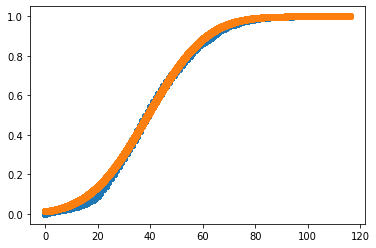

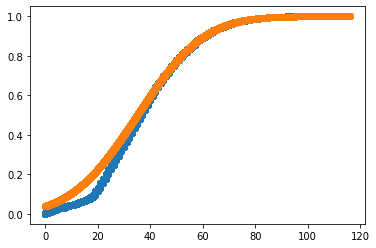

In [76]:
from scipy.stats import norm

def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

def grafico(media, variancia):
    """ Compute ECDF """
    x = np.arange(0,116,0.01)
    y = norm.cdf(x,media, variancia)
    return(x,y)
filtrando1 = dados.query('resultadoTeste == "Positivo" & classificacaoFinal == "Descartado"')
infectados1 = filtrando1['idade']

filtrando2 = dados.query('resultadoTeste == "Negativo" & classificacaoFinal != "Descartado"')
infectados2 = filtrando2['idade']

x,y = ecdf(infectados1)
plt.scatter(x=x, y=y);
#plt.plot(x,y)

x,y = grafico(39,17.5)
plt.scatter(x=x, y=y);
#plt.plot(x,y)

plt.show()


x,y = ecdf(infectados2)
plt.scatter(x=x, y=y);

x,y = grafico(35,20)
plt.scatter(x=x, y=y);

plt.show()
